# **Spatial Data Analysis and Parametric Modeling**

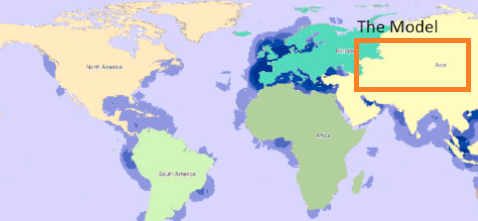

* In geographic information systems (GIS) and spatial data analysis, accurately classifying locations as either **land** or **sea** is a fundamental problem with numerous applications, from environmental monitoring to navigation systems.

* This classification problem involves determining whether a given geographic point falls within a designated land area or lies outside it, often within the context of a predefined **model** or boundary.

* In this example, we address the classification problem by implementing a simplified model that defines a rectangular **box** around known land points.

* Points inside this box are classified as land, while those outside are classified as sea.

* The model uses a set of sample land coordinates to determine the bounds of the box (**model parameters**), which is then used to classify additional test points.

## **Prior Probabilities**



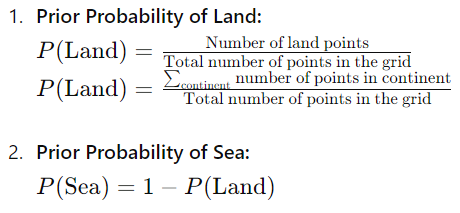

## **Distance Calculations**

* The **Euclidean distance** between a grid point (x,y) and the nearest land point (xi, yi) is calculated using the following formula:

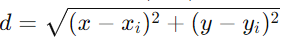


## **Likelihood Calculations**

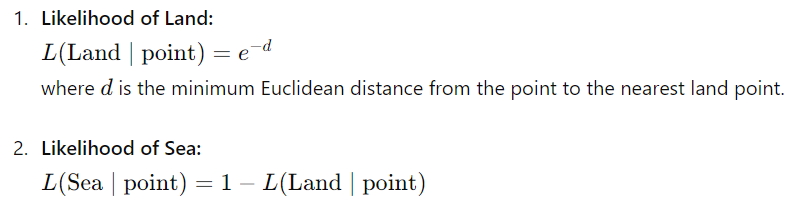

## **Classification**


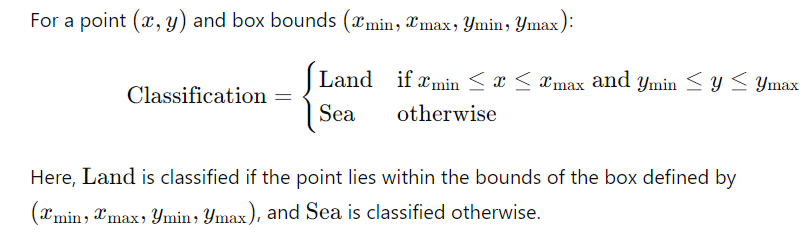



In [121]:
#@title Importing Libraries

# numerical operations
import numpy as np

# used for plotting
import matplotlib.pyplot as plt

# used for calculating distances
from scipy.spatial import distance

In [122]:
#@title Defining Known Land Mass Points

# A dictionary where each key is a continent and the value is a list of tuples
# representing points on that continent.

land_points = {
    'South America': [(-30, -60), (-15, -50), (0, -45), (15, -30), (30, -20)],
    'Australia': [(50, 10), (55, 0), (60, 10), (65, 20), (70, 30)],
    'Asia': [(20, 60), (30, 70), (40, 80), (50, 90), (60, 100)],
    'Africa': [(0, 20), (10, 20), (20, 30), (30, 40), (40, 50)],
    'Europe': [(-35, 140), (-30, 145), (-25, 150), (-20, 155), (-15, 160)]
}


In [123]:
#@title Defining a Grid of Points

# Create a grid of points with latitude ranging from -90 to 90 and longitude
# from -180 to 180 in steps of 10.

grid_points = [(x, y) for x in range(-90, 91, 10) for y in range(-180, 181, 10)]


In [124]:
#@title Calculating Prior Probabilities

# This function calculates the prior probabilities of a point being land or sea based on
# the number of land points versus the total points.

def calculate_prior_probabilities(land_points, total_points):
    P_land = sum(len(points) for points in land_points.values()) / total_points
    P_sea = 1 - P_land

    return P_land, P_sea



In [125]:
#@title Calculating Likelihoods

# This function calculates the likelihoods of points being land or sea based on their distances
# to the nearest land point.

# The likelihood decreases exponentially with increasing distance from land.

def calculate_likelihoods(grid_points, land_points):
    likelihoods_land = {}
    likelihoods_sea = {}

    all_land_points = [point for points in land_points.values() for point in points]

    for point in grid_points:
        distances_to_land = distance.cdist([point], all_land_points, 'euclidean').min()
        likelihoods_land[point] = np.exp(-distances_to_land)  # Exponential decay
        likelihoods_sea[point] = 1 - likelihoods_land[point]  # Opposite of land

    return likelihoods_land, likelihoods_sea


In [126]:
# This function classifies a point as 'Land' or 'Sea based on its likelihood of being land

def classify_point(point, likelihoods_land, likelihood_threshold=0.5):
    # Get likelihood of point being land
    likelihood_land = likelihoods_land.get(point, 0)

    # If likelihood is greater than threshold, classify as land, else sea
    if likelihood_land >= likelihood_threshold:
        return 'Land'
    else:
        return 'Sea'


In [127]:
#@title Plotting the Points and Model

# This functions plots the land points, test points, and the bounding box of
# the land model on a 2D plot, as well as "Coastline"

# Function to plot the points and the model
def plot_points(land_points, test_points, test_classifications, box_bounds):
    fig, ax = plt.subplots()

    # Define colors for each continent
    continent_colors = {
        'South America': 'green',
        'Europe': 'red',
        'Asia': 'blue',
        'Africa': 'purple',
        'Australia': 'orange'
    }

    coastline_color = 'yellow' # color for coastline

    # Plot land points by continent
    for continent, points in land_points.items():
        land_x, land_y = zip(*points)
        ax.scatter(land_x, land_y, color=continent_colors[continent], label=f'{continent}')

    # Highlight land model with an orange box
    x_min, x_max, y_min, y_max = box_bounds
    land_model_x = [x_min, x_max, x_max, x_min, x_min]
    land_model_y = [y_min, y_min, y_max, y_max, y_min]
    ax.plot(land_model_x, land_model_y, color='orange', label='Land Model')

    # Plot test points
    for point, classification in zip(test_points, test_classifications):
      if classification == 'Coastline':
        color = coastline_color
      elif classification == 'Land':
        color = 'green'
      else:
        color ='blue'
    ax.scatter(point[0], point[1], color=color, edgecolors='red', label=f'Test Point ({classification})')

    # Create legend using empty scatter plots
    ax.scatter([], [], color=coastline_color, edgecolors='red', label='Test Point (Coastline)')
    ax.scatter([], [], color='green', edgecolors='red', label='Test Point (Land)')
    ax.scatter([], [], color='blue', edgecolors='red', label='Test Point (Sea)')

    # Place the legend outside the plot box
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.title('Land, Coastline, and Sea Points with Model')
    plt.grid(False)  # Remove grid
    plt.show()




Test Point Classifications:
Point (100, 100): Sea
Point (40, -55): Sea
Point (10, 20): Land
Point (-100, -100): Sea
Point (25, 55): Sea
Point (20, 30): Land


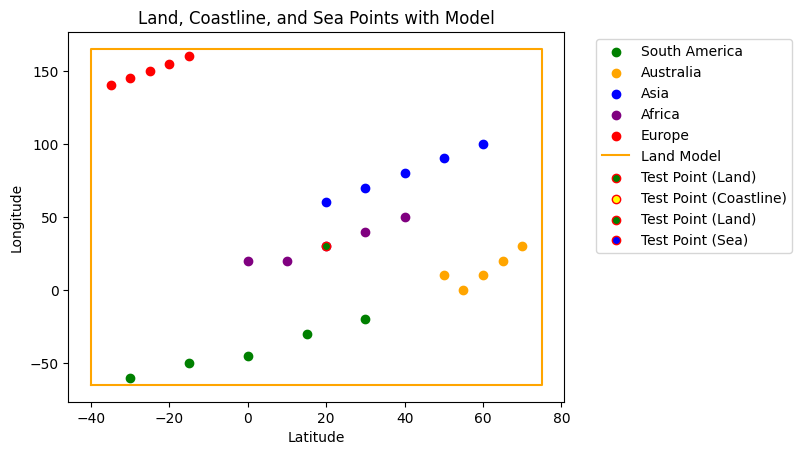

In [128]:
#@title Main Execution

# This section calculates the total grid points, prior probabilities, likelihoods,
# defines the model box, classifies test points, prints the classifications, and
# plots the points and the model.

# Total points in the grid
total_points = len(grid_points)

# Calculate prior probabilities
P_land, P_sea = calculate_prior_probabilities(land_points, total_points)

# Calculate likelihoods
likelihoods_land, likelihoods_sea = calculate_likelihoods(grid_points, land_points)

# Define the bounds of the model box
all_land_x = [point[0] for points in land_points.values() for point in points]
all_land_y = [point[1] for points in land_points.values() for point in points]
x_min, x_max = min(all_land_x) - 5, max(all_land_x) + 5
y_min, y_max = min(all_land_y) - 5, max(all_land_y) + 5
box_bounds = (x_min, x_max, y_min, y_max)

# Define the likelihood threshold for classification
likelihood_threshold = 0.5


 # Set of test points with varying distances to land masses
test_points = [
    (100, 100), (40,-55), (10, 20), (-100, -100), (25, 55), (20,30)

]

# Classify test points
test_classifications = [classify_point(point, likelihoods_land, likelihood_threshold) for point in test_points]

# Print test point classifications
print("\nTest Point Classifications:")
for point, classification in zip(test_points, test_classifications):
    print(f"Point {point}: {classification}")

# Plot the points and the model
plot_points(land_points, test_points, test_classifications, box_bounds)
